In [ ]:
import os
import re
import pandas as pd

''' ===== Configuration ===== '''
project_name = "Termite"
taxonomic_level = "Genus"  # Genus level

''' File path settings '''
base_path = f"/mnt/Data/{project_name}"
emu_output_path = os.path.join(base_path, "Termites_soil/emu_output")
bracken_output_path = os.path.join(base_path, "Termites_soil/kraken2_output/bracken")
emu_output_file = os.path.join(base_path, "emu_relabund_matrix.tsv")
bracken_output_file = os.path.join(base_path, "bracken_relabund_matrix.tsv")

''' ===== Function ===== '''
def extract_relative_abundance(data_path, taxonomic_level, source):
    taxonomic_key = taxonomic_level.lower() if source == "Emu" else taxonomic_level[0].upper()
    combined_data = []

    for data_file in os.listdir(data_path):
        file_path = os.path.join(data_path, data_file)
        if data_file.startswith("."):
            continue
        sample_id = re.match(r"([^\_.]+)", data_file).group(1)
        if not (os.path.isfile(file_path) and data_file.endswith(".tsv")):
            continue

        if source == "Emu":
            # Read Emu data
            df = pd.read_csv(file_path, sep="\t")
            taxa_column = next((col for col in df.columns if taxonomic_key in col.lower()), None)
            if not taxa_column:
                print(f"Skipping file {data_file}: Taxonomic level '{taxonomic_level}' not found.")
                continue

            df = df[[taxa_column, "abundance"]]
            df = df.groupby(taxa_column, as_index=False).sum()
            df = df.rename(columns={
                taxa_column: "Taxa",
                "abundance": f"EMU_{sample_id}"
            })

        elif source == "Bracken":
            if f"_{taxonomic_key}.tsv" not in data_file:
                continue
            df = pd.read_csv(file_path, sep="\t")
            required_columns = {"name", "fraction_total_reads"}
            if not required_columns.issubset(df.columns):
                print(f"Skipping file {data_file}: Missing required columns.")
                continue
            df = df.rename(columns={
                "name": "Taxa",
                "fraction_total_reads": f"Bracken_{sample_id}"
            })[["Taxa", f"Bracken_{sample_id}"]]

        if "Taxa" in df.columns:
            combined_data.append(df)

    if combined_data:
        combined_df = combined_data[0]
        for df in combined_data[1:]:
            combined_df = pd.merge(combined_df, df, on="Taxa", how="outer", suffixes=("", "_dup")).fillna(0)

        combined_df = combined_df.loc[:, ~combined_df.columns.str.endswith("_dup")]
        combined_df = combined_df[combined_df["Taxa"] != "0"]  # Exclude rows with "Taxa" == "0"
        return combined_df

    raise ValueError(f"No valid {source} files found in the specified path.")


''' ===== Workflow ===== '''
try:
    emu_relative_abundance_matrix = extract_relative_abundance(emu_output_path, taxonomic_level, "Emu")
    emu_relative_abundance_matrix.to_csv(emu_output_file, sep="\t", index=False)
    print(f"Emu relative abundance matrix saved to {emu_output_file}")
except ValueError as e:
    print(e)

try:
    bracken_relative_abundance_matrix = extract_relative_abundance(bracken_output_path, taxonomic_level, "Bracken")
    bracken_relative_abundance_matrix.to_csv(bracken_output_file, sep="\t", index=False)
    print(f"Bracken relative abundance matrix saved to {bracken_output_file}")
except ValueError as e:
    print(e)


Emu relative abundance matrix saved to /mnt/Huanglab/Data/2024-000012/emu_relabund_matrix.tsv
Bracken relative abundance matrix saved to /mnt/Huanglab/Data/2024-000012/bracken_relabund_matrix.tsv


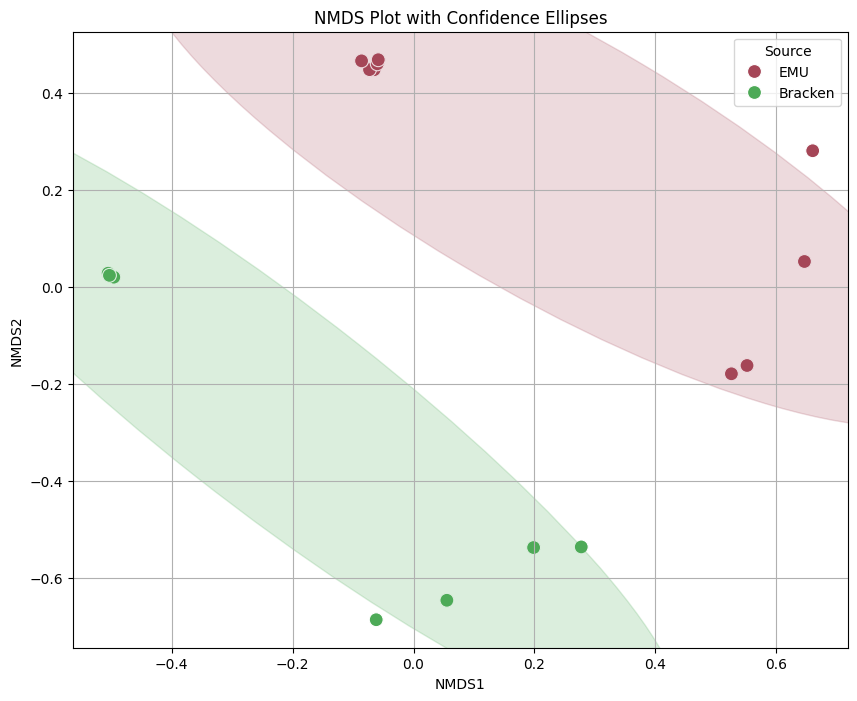

[[0.         0.70184704 0.8915555  0.89761354 0.12942765 0.38714855
  0.89982384 0.91543511 0.90318198 0.62678896 0.95098366 0.98836429
  0.98836429 0.63179558 0.83782569 0.98164369 0.98836429 0.98598398]
 [0.70184704 0.         0.92594678 0.93181797 0.760094   0.35923943
  0.93421512 0.95103558 0.93757326 0.98401074 0.98401074 1.
  1.         0.98562174 0.98401074 0.99414947 1.         1.        ]
 [0.8915555  0.92594678 0.         0.01169923 0.90671498 0.92202719
  0.02694301 0.04291766 0.03212457 0.95672408 0.98555604 0.68235172
  0.68235172 0.97398584 0.98344651 0.68235172 0.68235172 0.68235172]
 [0.89761354 0.93181797 0.01169923 0.         0.91362887 0.92894109
  0.0271002  0.04347286 0.03144578 0.95472185 0.98301864 0.67884433
  0.67884433 0.97398584 0.98090911 0.67884433 0.67884433 0.67884433]
 [0.12942765 0.760094   0.90671498 0.91362887 0.         0.43562652
  0.91366062 0.92866665 0.91567511 0.59684647 0.95554193 0.99376904
  0.99376904 0.57193612 0.83780242 0.98582832 0.9937

ValueError: Length mismatch: Expected axis has 18 elements, new values have 55 elements

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as patches
from scipy.spatial.distance import cdist

''' ===== Configuration ===== '''
project_id = "2024-000012"

''' File path settings '''
base_path = f"/mnt/Huanglab/Data/{project_id}"
emu_output_file = os.path.join(base_path, "emu_relabund_matrix.tsv")
bracken_output_file = os.path.join(base_path, "bracken_relabund_matrix.tsv")

''' ===== Function ===== '''
emu_df = pd.read_csv(emu_output_file, sep="\t")
bracken_df = pd.read_csv(bracken_output_file, sep="\t")
combined_df = pd.merge(emu_df, bracken_df, on="Taxa", how="outer").fillna(0)
abundance_data = combined_df.drop("Taxa", axis=1)
abundance_data_transposed = abundance_data.T
abundance_data_normalized = normalize(abundance_data_transposed, axis=1, norm='l1')
bray_curtis_dist = pairwise_distances(abundance_data_normalized, metric="braycurtis")

nmds = MDS(n_components=2, metric=True, dissimilarity="precomputed", random_state=42, normalized_stress="auto")
nmds_coords = nmds.fit_transform(bray_curtis_dist)

nmds_df = pd.DataFrame(nmds_coords, columns=["NMDS1", "NMDS2"])
nmds_df["Source"] = ["EMU" if "EMU" in sample else "Bracken" for sample in abundance_data.columns]

def draw_confidence_ellipse(ax, x, y, label, color, n_std=1.96):
    """Draw a confidence ellipse for a group of points."""
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    eigvals, eigvecs = np.linalg.eig(cov)
    width, height = 2 * n_std * np.sqrt(eigvals)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    ellipse = patches.Ellipse(
        (mean_x, mean_y), width, height, angle=angle, color=color, alpha=0.2
    )
    ax.add_patch(ellipse)

# Create the plot
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Scatter plot for NMDS points
sns.scatterplot(
    x="NMDS1", y="NMDS2", hue="Source", data=nmds_df, palette=["#A54657", "#4DAA57"], s=100, ax=ax
)

# Add confidence ellipses for each group
for label, group in nmds_df.groupby("Source"):
    draw_confidence_ellipse(ax, group["NMDS1"], group["NMDS2"], label, "#A54657" if label == "EMU" else "#4DAA57")

# Finalize the plot
plt.title("NMDS Plot with Confidence Ellipses")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.legend(title="Source")
plt.grid(True)
plt.show()

# Create a new DataFrame for the Bray-Curtis distances
bray_curtis_boxplot_df = pd.DataFrame(bray_curtis_dist)
print(bray_curtis_dist)
print(bray_curtis_boxplot_df)

# Assign sample names from the abundance_data columns to the rows and columns
bray_curtis_boxplot_df.index = abundance_data.index
bray_curtis_boxplot_df.columns = abundance_data.index

# Melt the matrix into a long-form DataFrame
bray_curtis_long = bray_curtis_boxplot_df.reset_index().melt(
    id_vars="index", var_name="Sample2", value_name="Dissimilarity"
)
bray_curtis_long.columns = ["Sample1", "Sample2", "Dissimilarity"]

# Map "Source" labels for Sample1 and Sample2
sample_sources = {
    sample: "EMU" if "Emu" in sample else "Bracken" for sample in abundance_data.index
}
bray_curtis_long["Source1"] = bray_curtis_long["Sample1"].map(sample_sources)
bray_curtis_long["Source2"] = bray_curtis_long["Sample2"].map(sample_sources)

# Filter pairwise comparisons: keep only intra-group comparisons (EMU vs EMU or Bracken vs Bracken)
filtered_bc = bray_curtis_long[
    (bray_curtis_long["Source1"] == bray_curtis_long["Source2"])
]

# Assign a new variable for Bray-Curtis boxplot data
bray_curtis_boxplot_df = filtered_bc.copy()

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Source1", y="Dissimilarity", data=bray_curtis_boxplot_df, palette=["#A54657", "#4DAA57"]
)
sns.stripplot(
    x="Source1", y="Dissimilarity", data=bray_curtis_boxplot_df, color="black", size=4, alpha=0.7, jitter=True
)

# Customize the plot
plt.title("Community Composition Differences: EMU vs Bracken (Bray-Curtis Dissimilarity)")
plt.xlabel("Source")
plt.ylabel("Bray-Curtis Dissimilarity")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import Ellipse
from skbio.stats.ordination import pcoa
from scipy.stats import mannwhitneyu

''' ===== Configuration ===== '''
project_id = "2024-000012"

''' File path settings '''
base_path = f"/mnt/Huanglab/Data/{project_id}"
emu_file = os.path.join(base_path, "emu_relabund_matrix.tsv")
bracken_file = os.path.join(base_path, "bracken_relabund_matrix.tsv")
output_file = os.path.join(base_path, "comb_matrix.tsv")

''' ===== Functions ===== '''
def combine_matrices(bracken_file, emu_file, output_file):
    bracken_df = pd.read_csv(bracken_file, sep='\t')
    emu_df = pd.read_csv(emu_file, sep='\t')

    # Strip prefixes to get consistent sample IDs
    bracken_df.rename(columns=lambda x: x.replace("Bracken_", ""), inplace=True)
    emu_df.rename(columns=lambda x: x.replace("EMU_", ""), inplace=True)

    # Merge and fill missing values
    combined_df = pd.merge(bracken_df, emu_df, on='Taxa', how='outer', suffixes=("_Bracken", "_EMU"))
    combined_df.fillna(0.0, inplace=True)
    combined_df.to_csv(output_file, sep='\t', index=False)
    return combined_df

def extract_sample_data(combined_df):
    # Identify columns for Bracken and EMU
    bracken_cols = [col for col in combined_df.columns if col.endswith("_Bracken")]
    emu_cols = [col for col in combined_df.columns if col.endswith("_EMU")]

    # Ensure same sample IDs are compared
    sample_ids_bracken = set(col.replace("_Bracken", "") for col in bracken_cols)
    sample_ids_emu = set(col.replace("_EMU", "") for col in emu_cols)
    common_samples = sample_ids_bracken & sample_ids_emu

    # Filter data for common samples
    bracken_data = combined_df[["Taxa"] + [f"{sample}_Bracken" for sample in common_samples]]
    emu_data = combined_df[["Taxa"] + [f"{sample}_EMU" for sample in common_samples]]

    # Combine into a single matrix
    combined_data = pd.concat([bracken_data.set_index("Taxa"), emu_data.set_index("Taxa")], axis=1)
    return combined_data, list(common_samples)

def perform_nmds(combined_data):
    # Transpose the data to have samples as rows and taxa as columns
    data = combined_data.T

    # Compute Bray-Curtis dissimilarity matrix
    dissimilarity_matrix = squareform(pdist(data, metric='braycurtis'))

    # Perform NMDS
    mds = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed', random_state=42)
    nmds_coords = mds.fit_transform(dissimilarity_matrix)
    return nmds_coords

def perform_pcoa(combined_data):
    # Transpose the data to have samples as rows and taxa as columns
    data = combined_data.T

    # Compute Bray-Curtis dissimilarity matrix
    dissimilarity_matrix = squareform(pdist(data, metric='braycurtis'))

    # Perform PCoA
    pcoa_results = pcoa(dissimilarity_matrix)
    eigvals = pcoa_results.eigvals
    ratio = abs(eigvals.min()) / eigvals.max()
    print(f"Ratio of smallest negative to largest positive eigenvalue: {ratio}")
    return pcoa_results.samples.iloc[:, :2].values

def plot_analysis(coords, title, sample_labels, groups):
    # Prepare a DataFrame for plotting
    analysis_df = pd.DataFrame(coords, columns=["Axis1", "Axis2"])
    analysis_df["Group"] = groups

    # Plot analysis with confidence ellipses
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("Set2")
    group_colors = dict(zip(analysis_df["Group"].unique(), palette))
    sns.scatterplot(data=analysis_df, x="Axis1", y="Axis2", hue="Group", s=100, palette=group_colors)

    # Add confidence ellipses
    for group in analysis_df["Group"].unique():
        subset = analysis_df[analysis_df["Group"] == group]
        cov = np.cov(subset[["Axis1", "Axis2"]].T)
        mean = subset[["Axis1", "Axis2"]].mean().values
        eigvals, eigvecs = np.linalg.eigh(cov)
        width, height = 2 * np.sqrt(eigvals)
        angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, alpha=0.2, color=group_colors[group])
        plt.gca().add_patch(ellipse)

    plt.title(title)
    plt.legend()
    #plt.show()
    plt.savefig(os.path.join(base_path, f"{title.replace(' ', '_')}.png"))
    plt.close()

def plot_braycurtis_boxplot(combined_data):
    bracken_cols = [col for col in combined_data.columns if col.endswith("_Bracken")]
    emu_cols = [col for col in combined_data.columns if col.endswith("_EMU")]

    bracken_dissimilarity = pdist(combined_data[bracken_cols].T, metric='braycurtis')
    emu_dissimilarity = pdist(combined_data[emu_cols].T, metric='braycurtis')

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(bracken_dissimilarity, emu_dissimilarity, alternative='two-sided')
    print(f"Mann-Whitney U test p-value: {p_value}")

    # Prepare data for boxplot
    data = {
        "Bracken": bracken_dissimilarity,
        "EMU": emu_dissimilarity
    }
    df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data.items()]))

    # Plot boxplots without outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, showfliers=False)
    plt.ylabel("Bray-Curtis Dissimilarity")
    plt.text(0.5, max(df.max()) * 0.95, f"p = {p_value:.4f}", ha='center', fontsize=12)
    #plt.show()
    plt.savefig(os.path.join(base_path, "bray-curtis_boxplot.png"))
    plt.close()

# Example usage
combined_df = combine_matrices(bracken_file, emu_file, output_file)
combined_data, common_samples = extract_sample_data(combined_df)
nmds_coords = perform_nmds(combined_data)
pcoa_coords = perform_pcoa(combined_data)
groups = ["Bracken" if "Bracken" in col else "EMU" for col in combined_data.columns]
plot_analysis(nmds_coords, "NMDS Analysis", combined_data.columns, groups)
plot_analysis(pcoa_coords, "PCoA Analysis", combined_data.columns, groups)
plot_braycurtis_boxplot(combined_data)


/usr/local/lib/python3.10/dist-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.07857636290391946 and the largest is 2.6771702665304717.
  warn(


Ratio of smallest negative to largest positive eigenvalue: 0.0
Mann-Whitney U test p-value: 0.10126421860977511
